In [6]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [7]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [9]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

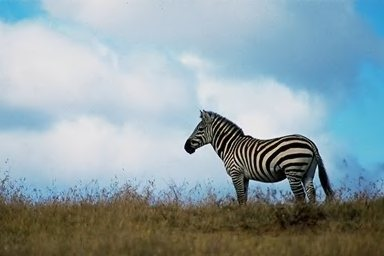

In [10]:
real_image_path = 'C:\\Users\\Ruti\\Desktop\\CASIA2\\Au\\Au_ani_00001.jpg'
Image.open(real_image_path)

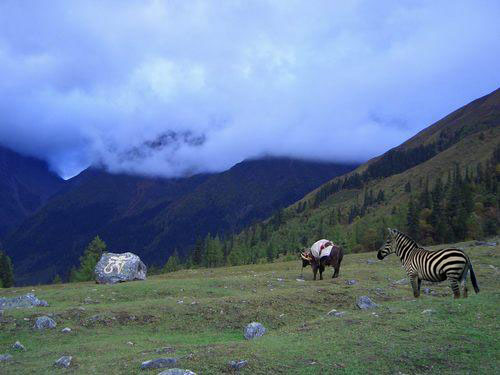

In [13]:
fake_image_path = 'C:\\Users\\Ruti\\Desktop\\CASIA2\\Tp\\Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

In [14]:
image_size = (128, 128)

In [15]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [16]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [18]:
import random
path = 'C:\\Users\\Ruti\\Desktop\\CASIA2\\Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [19]:
path = 'C:\\Users\\Ruti\\Desktop\\CASIA2\\Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [20]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [22]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [24]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

c:\users\ruti\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [27]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 [==============================] - 284s 3s/step - loss: 0.4991 - accuracy: 0.7385 - val_loss: 0.3348 - val_accuracy: 0.8848
Epoch 2/30
105/105 [==============================] - 311s 3s/step - loss: 0.3241 - accuracy: 0.8946 - val_loss: 0.3221 - val_accuracy: 0.8872
Epoch 3/30
105/105 [==============================] - 139s 1s/step - loss: 0.3134 - accuracy: 0.8874 - val_loss: 0.2992 - val_accuracy: 0.8944
Epoch 4/30
105/105 [==============================] - 126s 1s/step - loss: 0.2770 - accuracy: 0.9075 - val_loss: 0.2777 - val_accuracy: 0.8992
Epoch 5/30
105/105 [==============================] - 129s 1s/step - loss: 0.2540 - accuracy: 0.9126 - val_loss: 0.2663 - val_accuracy: 0.9028
Epoch 6/30
105/105 [==============================] - 131s 1s/step - loss: 0.2373 - accuracy: 0.9129 - val_loss: 0.2491 - val_accuracy: 0.9052
Epoch 7/30
105/105 [==============================] - 139s 1s/step - loss: 0.2120 - accuracy: 0.9225 - val_loss: 0.2367 - val_accuracy: 0.9076

Epoch 23/30
105/105 [==============================] - 135s 1s/step - loss: 0.0591 - accuracy: 0.9820 - val_loss: 0.1863 - val_accuracy: 0.9376
Epoch 24/30
105/105 [==============================] - 131s 1s/step - loss: 0.0535 - accuracy: 0.9847 - val_loss: 0.1834 - val_accuracy: 0.9412
Epoch 25/30
105/105 [==============================] - 132s 1s/step - loss: 0.0471 - accuracy: 0.9877 - val_loss: 0.2328 - val_accuracy: 0.9388
Epoch 26/30
105/105 [==============================] - 134s 1s/step - loss: 0.0522 - accuracy: 0.9859 - val_loss: 0.2157 - val_accuracy: 0.9316
Epoch 27/30
105/105 [==============================] - 132s 1s/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.2143 - val_accuracy: 0.9256
Epoch 28/30
105/105 [==============================] - 132s 1s/step - loss: 0.0388 - accuracy: 0.9904 - val_loss: 0.2149 - val_accuracy: 0.9316
Epoch 29/30
105/105 [==============================] - 135s 1s/step - loss: 0.0360 - accuracy: 0.9907 - val_loss: 0.2255 - val_accuracy:

In [2]:
from joblib import dump, load

# Save the model

dump(model, 'model.joblib')

# Load the model
# loaded_model = load('../../../model.joblib')


Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-06-15 21:52:22         3486
metadata.json                                  2023-06-15 21:52:22           64
variables.h5                                   2023-06-15 21:52:24    118105960
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...vars


In [29]:
class_names = ['fake', 'real']
real_image_path = 'C:\\Users\\Ruti\\Desktop\\CASIA2\\Tp\\Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]}, Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 60ms/step
Class: fake, Confidence: 99.80


In [40]:
fake_image_path = 'C:\\Users\\Ruti\\Desktop\\d.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]}, Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 40ms/step
Class: real, Confidence: 100.00
